In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import os
from os import walk
import glob as gb
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

In [14]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [15]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

SEED = 1000
IMG_SIZE = 50
BATCH_SIZE = 128

In [16]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [17]:
def identity_block(X, filters):
    f1, f2, f3 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [18]:
def conv_blocks(X, filters, s=2):
    f1, f2, f3 = filters
    X_copy = X
    
    # 1st Layer
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    # 2nd Layer
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    # 3rd Layer
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    ### match the dimension
    X_copy = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid')(X_copy)
    X_copy = layers.BatchNormalization(axis=3)(X_copy)
    
    # Add the Skip COnnection
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [19]:
def ResNet50():
    X_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    X = layers.ZeroPadding2D((3,3))(X_input)
    
    # Satge Conv1
    X = layers.Conv2D(64, (7,7), strides=(2,2))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    X = layers.MaxPooling2D((3,3), strides=(2,2))(X)
    
    # stage Conv2_x
    X = conv_blocks(X, filters=[64,64,256], s=1)
    X = identity_block(X, filters=[64,64,256])
    X = identity_block(X, filters=[64,64,256])
    
    # stage Conv3_x
    X = conv_blocks(X, filters=[128,128,512], s=2)
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    
    # stage Conv4_x
    X = conv_blocks(X, filters=[256,256,1024], s=2)
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    
    # stage Conv5_x
    X = conv_blocks(X, filters=[512,512,2048], s=2)
    X = identity_block(X, filters=[512,512,2048])
    X = identity_block(X, filters=[512,512,2048])
    
    
    X = layers.AveragePooling2D((2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(10, activation='softmax', kernel_initializer='he_normal')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [20]:
model = ResNet50()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 56, 56, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 25, 25, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 25, 25, 64)   256         conv2d_13[0][0]                  
___________________________________________________________________________________________

In [21]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=lr_schedule(0)), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

Learning rate:  0.001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
h = model.fit(X_train, 
              epochs=50,
              steps_per_epoch = X_train // BATCH_SIZE,
              validation_split = 0.2,
              validation_steps = 100,
              callbacks=lr_scheduler,
              verbose=2
             )

ValueError: ignored

In [24]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

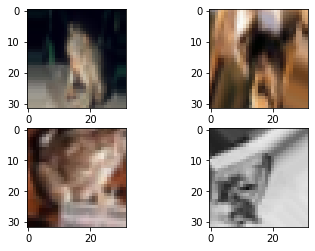

In [25]:
datagen.fit(X_train)

for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=4, seed=1000):
  for i in range(0,4):
    plt.subplot(220 +1 +i)
    plt.imshow(X_batch[i])
  plt.show()
  break
